In [1]:
import gc

In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from fastai.text.all import *

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

#### Fine-tuning GPT-2 model on Amazon Dataset Reviews
Data source: https://nijianmo.github.io/amazon/index.html

In [4]:
DATA_ROOT = Path("..") / "data/Books_5/"
df = pd.read_csv(DATA_ROOT / 'data.csv', sep=",")

In [5]:
df.head()

,reviewText
0,"The King, the Mice and the Cheese by Nancy Gurney is an excellent children's book. It is one that I well remember from my own childhood and purchased for my daughter who loves it.\n\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away. The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that'd chased away the dogs.\n\nThe story ends i..."
1,The kids loved it!
2,My students (3 & 4 year olds) loved this book! Definitely recommend it to other teachers.
3,LOVE IT
4,Great!


In [6]:
sample_df = df.sample(n=50000, random_state=2021).dropna().reset_index()

In [7]:
del df
gc.collect()

368

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_train, df_valid = train_test_split(sample_df, random_state=2021, test_size=0.1)

In [10]:
all_texts = np.concatenate([df_train["reviewText"].values, df_valid["reviewText"].values])

In [11]:
all_texts.shape

(49995,)

In [12]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [13]:
splits = [list(df_train.index), list(df_valid.index)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [14]:
tls.train[0]

tensor([  464,  1738,   314,  6497,   510,   428,  1492,   373,   780,   314,
         2497,   326,   257,  3807,   373,   852,   925,   329,   340,    13,
        11204, 11040,   314,  3066,   284,  1577,   340,   257,  2823,    13,
         3914,   502,  1560,   345,   428,  1492,  2753,   345,   319,   884,
          257,  6594,    13,   383,  1492,   481,  1394,   345, 25260,   290,
          772,   379,   262,   886,   618,   345,   892,   663,   477, 12939,
          345,   481,   765,   284,   467,   284,   262,  1306,  1492,   655,
          284,   766,   644,  4325,    13])

In [15]:
tls.valid[0]

tensor([ 1212,   373,  6833,  2449, 30921, 16929,    13,   314,  1107,  8359,
          340,    13])

In [16]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([75]), torch.Size([12]))

In [17]:
show_at(tls.train, 0)

The reason I picked up this book was because I saw that a movie was being made for it. Being curious I decided to give it a shot. Let me tell you this book takes you on such a ride. The book will keep you guessing and even at the end when you think its all resolved you will want to go to the next book just to see what happens.


In [18]:
show_at(tls.valid, 0)

This was classic Agatha Christie. I really enjoyed it.


In [19]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1602 > 1024). Running this sequence through the model will result in indexing errors


In [20]:
dls.show_batch(max_n=2)

,text,text_
0,"I bought this book for preparing for SUn Certfied Enterprise Architect assignment( part II). I am very happy with this book. It gives examples for all J2EE patterns in a very lucid way and this book has helped me a lot.In this second book in the series Stephanie Plum proves herself to be the worst bounty hunter around. She's inept, easily frightened and doesn't like to carry or fire a gun. When she and Grandma team up, they become a hilarious deadly duo. This was a quick, fun read.An important resource when concerned with the debate about guns and violence in American society. This book deals with facts, meticulously researched and eliminates the emotionalism that so often permeates this issue. It has held up well after nearly 2 decades and no one has been able to seriously undermine or refute the conclusions.Very dangerous advice that goes against","bought this book for preparing for SUn Certfied Enterprise Architect assignment( part II). I am very happy with this book. It gives examples for all J2EE patterns in a very lucid way and this book has helped me a lot.In this second book in the series Stephanie Plum proves herself to be the worst bounty hunter around. She's inept, easily frightened and doesn't like to carry or fire a gun. When she and Grandma team up, they become a hilarious deadly duo. This was a quick, fun read.An important resource when concerned with the debate about guns and violence in American society. This book deals with facts, meticulously researched and eliminates the emotionalism that so often permeates this issue. It has held up well after nearly 2 decades and no one has been able to seriously undermine or refute the conclusions.Very dangerous advice that goes against"
1,"(or -""ahead"") which has become standard in popular fiction. As used by Lindsay, these serve the purpose, but are also an eloquent introduction to Dexter.\n\nThe real story begins with the discovery of the bloodless dissected/disarticulated corpse of a prostitute, on a section of SW 8th Street (Calle Ocho) where Dexter's foster sister Debra is working vice, dressed as a prostitute. Debra desperately wants out of the vice squad into the detective department.\n\nAs the story develops, similarities between Dexter's methods and the killer's methods become more evident. Moreover, Dexter has ""visions"" of what the killer is doing, and the killer seems to know what Dexter is doing. Dexter begins to worry that he himself may be the killer, ""sleep killing"".\n\nTHE VERDICT\nDexter is an intriguing character. The plot is well paced, and captivating.\n\n> Click on Stoney just below the product title to see my other reviews, or","or -""ahead"") which has become standard in popular fiction. As used by Lindsay, these serve the purpose, but are also an eloquent introduction to Dexter.\n\nThe real story begins with the discovery of the bloodless dissected/disarticulated corpse of a prostitute, on a section of SW 8th Street (Calle Ocho) where Dexter's foster sister Debra is working vice, dressed as a prostitute. Debra desperately wants out of the vice squad into the detective department.\n\nAs the story develops, similarities between Dexter's methods and the killer's methods become more evident. Moreover, Dexter has ""visions"" of what the killer is doing, and the killer seems to know what Dexter is doing. Dexter begins to worry that he himself may be the killer, ""sleep killing"".\n\nTHE VERDICT\nDexter is an intriguing character. The plot is well paced, and captivating.\n\n> Click on Stoney just below the product title to see my other reviews, or leave"


#### Fine-tuning the model

In [21]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [22]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [23]:
learn.validate()

(#2) [3.7357964515686035,41.92140197753906]

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

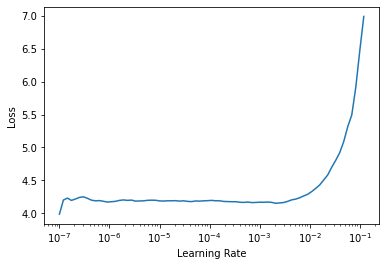

In [32]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.520243,3.487821,32.714573,2:31:39


In [25]:
learn.save("gpt2-finetuned-amazon-reviews-sample-1cycle-Books_5")

Path('models/gpt2-finetuned-amazon-reviews-sample-1cycle-Books_5.pth')

In [35]:
df_valid.head(1)

,index,reviewText
17432,1013850,"Haven't bought the new and improved edition of ""Viva"" yet, but you can't go wrong with the tracks featured here. The scintillating ""Margaret on the Guillotine"" sums it all up: clever, cunning, and cutting. Morrissey is in remarkably clear voice throughout, and his lyrics are alternately verbose, focused, and incredibly deep(""Everyday is Like Sunday"", a ballad about a hoped-for end of the world, remains one of his most trenchant and yet appealing songs). This is terribly sophisticated and intricate music, crisply produced and arranged with delicate malice."


In [57]:
prompt = "Looked good in pictures, fabric is also"

In [58]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 9])

In [59]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=0.75, early_stopping=True, no_repeat_ngram_size=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [60]:
tokenizer.decode(preds[0].cpu().numpy())

'Looked good in pictures, fabric is also very soft.  I would recommend this product to anyone looking for a good quality fabric for the price.This is a great product. I have used it'

In [61]:
prompt = "Not satisfied with the product"

In [62]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 5])

In [71]:
preds = learn.model.generate(inp, max_length=50, num_beams=5, temperature=0.75, early_stopping=True, no_repeat_ngram_size=2, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [72]:
tokenizer.decode(preds[0].cpu().numpy())

'Not satisfied with the product.  I would not recommend this product to anyone.This is one of the best albums I have ever listened to. It is a great album, but it is not as good as the first one. The second one is'

In [74]:
for i, pred in enumerate(preds):
  print("{}: {}".format(i, tokenizer.decode(pred, skip_special_tokens=True)))

0: Not satisfied with the product.  I would not recommend this product to anyone.This is one of the best albums I have ever listened to. It is a great album, but it is not as good as the first one. The second one is
1: Not satisfied with the product.  I would not recommend this product to anyone.This is one of the best albums I have ever listened to. It is a great album, but it is not as good as the first album. The second album is
2: Not satisfied with the product.  I would not recommend this product to anyone.This is one of the best albums I have ever listened to. It is a great album, but it is not as good as the first album. The second one is
3: Not satisfied with the product.  I would not recommend this product to anyone.This is one of the best albums I have ever listened to. It is a great album, and I highly recommend it to all of you.I love this case.
4: Not satisfied with the product.  I would not recommend this product to anyone.This is one of the best albums I have ever listen

In [75]:
prompt = "This mobile cover"

In [76]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 3])

In [77]:
preds = learn.model.generate(inp, max_length=50, num_beams=5, temperature=0.75, early_stopping=True, no_repeat_ngram_size=2, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [78]:
tokenizer.decode(preds[0].cpu().numpy())

'This mobile cover is a great addition to your phone.  It is easy to put on and off, and it has a nice feel to it.\n\nI would highly recommend this cover to anyone looking for a cover that will protect their phone from'

In [79]:
for i, pred in enumerate(preds):
  print("{}: {}".format(i, tokenizer.decode(pred, skip_special_tokens=True)))

0: This mobile cover is a great addition to your phone.  It is easy to put on and off, and it has a nice feel to it.

I would highly recommend this cover to anyone looking for a cover that will protect their phone from
1: This mobile cover is a great addition to your phone.  It is easy to put on and off, and it has a nice feel to it.

I would recommend this cover to anyone looking for a cover that will protect their phone from scratches
2: This mobile cover is a great addition to your phone.  It is easy to put on and off, and it has a nice feel to it.

I would recommend this cover to anyone looking for a cover that will protect their phone from the
3: This mobile cover is a great addition to your phone.  It is easy to put on and off, and it has a nice feel to it.

I would highly recommend this cover to anyone looking for a cover that will protect their phone and
4: This mobile cover is a great addition to your phone.  It is easy to put on and off, and it has a nice feel to it.

I would

In [96]:
prompt = "This has helped me so much"

In [97]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 6])

In [98]:
preds = learn.model.generate(inp, max_length=50, num_beams=5, temperature=0.75, early_stopping=True, no_repeat_ngram_size=2, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [99]:
tokenizer.decode(preds[0].cpu().numpy())

"This has helped me so much in my life.  It's a great way to keep track of what's going on in your life and what you need to do to make it better.\n\nI've been using this for about a year now"

In [100]:
for i, pred in enumerate(preds):
  print("{}: {}".format(i, tokenizer.decode(pred, skip_special_tokens=True)))

0: This has helped me so much in my life.  It's a great way to keep track of what's going on in your life and what you need to do to make it better.

I've been using this for about a year now
1: This has helped me so much in my life.  It's a great way to keep track of what's going on in your life and what you need to do to get it done.

I've been using this for about a year now
2: This has helped me so much in my life.  It's a great way to keep track of what's going on in your life and what you need to do to get it done.

I've been using this for a while now and
3: This has helped me so much in my life.  It's a great way to keep track of what's going on in your life and what you need to do to make it better.

I've been using this for a while now and
4: This has helped me so much in my life.  It's a great way to keep track of what's going on in your life and what you need to do to make it better.

I've been using this for about a month now


#### Sampling

In [101]:
prompt = "This has helped me so much"

In [102]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 6])

In [106]:
preds = learn.model.generate(inp, max_length=50, do_sample=True, top_k=0, num_return_sequences=5, temperature=0.7)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [107]:
tokenizer.decode(preds[0].cpu().numpy())

"This has helped me so much.  The only reason that I don't give it a 2 star is because of the quality of the phone.  I was hoping for a better case, but, it appears that it was not as sleek as I"

In [108]:
for i, pred in enumerate(preds):
  print("{}: {}".format(i, tokenizer.decode(pred, skip_special_tokens=True)))

0: This has helped me so much.  The only reason that I don't give it a 2 star is because of the quality of the phone.  I was hoping for a better case, but, it appears that it was not as sleek as I
1: This has helped me so much. And I have used it once before and it works great. I have used it on my phone 3 times and it lasts me a night. I have a couple of other phones and the quality is excellent. I have
2: This has helped me so much.Very good flaps.  Has a very nice, flexible plastic bottom to hold the screws that hold the wiper to the rims on the handle.  I have been using these to hold the rims from
3: This has helped me so much in the past. I can now see what the bag is made of. I have to ask about it before I buy it. I will likely get another one for my son. I can't wait to get the package
4: This has helped me so much. The remastering is a real plus. I just wish it was better.

I'm going to continue to listen to this music.good productVery nice case.  very nice.  I like that


#### top-k sampling

In [109]:
prompt = "This has helped me so much"

In [110]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 6])

In [111]:
preds = learn.model.generate(inp, max_length=50, do_sample=True, top_k=50, num_return_sequences=5, temperature=0.7)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [112]:
tokenizer.decode(preds[0].cpu().numpy())

"This has helped me so much in the past.  It's really easy to use and it's very easy to apply.  Just grab your phone and put it on the mat.  Then take the phone and put your hand over the mat."

In [113]:
for i, pred in enumerate(preds):
  print("{}: {}".format(i, tokenizer.decode(pred, skip_special_tokens=True)))

0: This has helped me so much in the past.  It's really easy to use and it's very easy to apply.  Just grab your phone and put it on the mat.  Then take the phone and put your hand over the mat.
1: This has helped me so much. I still get my coffee, but the flavor is a little bitter. This is a very good coffee at $1.99 a cup. It is a very good coffee at $5.59. I would buy
2: This has helped me so much.  I could not be happier with this purchase.  I have made so many friends with the same product.  I hope they will not stop using this product again.  Thank you.  I am so glad
3: This has helped me so much and I still get used to it!

I've had two different cases but this one is the one I wanted and was perfect. It is the only case I have never had problems with. I would recommend it
4: This has helped me so much. I have a small pond in the backyard and this is an amazing pond. I have ponded it twice on my pond and it still holds up very well. I have been using this pond for a long time an

#### top-p nucleus sampling

In [114]:
prompt = "This has helped me so much"

In [115]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 6])

In [116]:
preds = learn.model.generate(inp, max_length=50, do_sample=True, top_k=0, top_p=0.92, num_return_sequences=5, temperature=0.7)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [117]:
tokenizer.decode(preds[0].cpu().numpy())

'This has helped me so much. I keep my two cell phones charged and charged. It was a little hard to put on because it had the right height and I had to pull my phone out of the charger. I did it by holding the phone'

In [118]:
for i, pred in enumerate(preds):
  print("{}: {}".format(i, tokenizer.decode(pred, skip_special_tokens=True)))

0: This has helped me so much. I keep my two cell phones charged and charged. It was a little hard to put on because it had the right height and I had to pull my phone out of the charger. I did it by holding the phone
1: This has helped me so much since I was a kid.  The band has changed the way I think about music and I like that they've made a little more music than the typical radio and TV.  When I saw this CD, I was
2: This has helped me so much.I love this tea. I have tried several brands and this one has the best flavor. The tea is just so strong, I can take it away from my glee. I enjoy the taste of coffee, but
3: This has helped me so much.  I have had this for three years now and it works well.  I have a friend who works at a local auto repair shop and it works perfectly.  I have to tell you this is the first time
4: This has helped me so much in my life.  I know I will be buying this again.I'm a bit concerned about the way the photo has been taken. I'm not sure if the quality